Import basic numerical and plottign libraries

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

The `scipy` library is used for signal operations (filters, Hilbert and Fourier transforms).

In [4]:
from scipy import signal, fftpack

The Pandas library is used for loading data into a convenient form.

In [5]:
import pandas as pd

We will be working with example data from the  following discharge

In [6]:
shot_no = 18685

# Explanation of the original algorithm

The [original algorithm](http://golem.fjfi.cvut.cz/shots/18685/diagnostics/Microwaves/0712Interferometer.ON/main.py) used for the [result displayed on the website](http://golem.fjfi.cvut.cz/shots/18685/diagnostics/Microwaves/0712Interferometer.ON/01_Demodulated%20signal.php) is essentially a simplified phase demodulation algorithm. Its main goal is to obtain the instantaneous phase $\theta(t)$ of the measured sine wave. The difference between this phase and the phase of the reference frequency sweeping wave is then proportional to the line-averaged plasma density $n_e \propto \theta(t) - \varphi_{ref}$.


# Phase demodulation using the analytic signal representation.

The **analytic signal representation** is motivated by the fact that for a purely real signal $f(t)$ its Fourier transform has Hermitian symmetry $\hat f(-\omega) = \overline{\hat f(\omega)}$, so the negative frequencies can be discarded without loss of information.

Therefore, given a harmonic wave signal $$s(t) = A \cos(\omega t + \theta) = A\frac{1}{2}\left(e^{i(\omega t + \theta)} + e^{-i(\omega t + \theta)}\right)$$ it can be represented by a complex signal  $s_a(t) = A\cdot e^{i(\omega t + \theta(t))}$ without loss of generality. This *analytic representation* is essentially the original signal without its negative frequency components and the positive ones doubled to retain the same amplitude.

Once we have the complex signal $s_a(t)$, we can simply obtain the phase $\theta$ by transforming this complex signal into the polar representation for complex numbers 
\begin{align*}
\omega t + \theta &= \mathrm{arg}[s_a(t)]\\
A &= |s_a(t)|
\end{align*}

This approach will work when the phase is a  function of time $\theta(t)$, but may fail if the amplitude significantly changes as well.

We can perform the same demodulation of the reference frequency generator signal $f_{ref}(t) = \mathrm{sawtooth}(\omega t + \varphi_{ref})$ and then calculate the difference of their instantaneous phases $$n_e \propto (\omega t +\theta(t)) - (\omega t +\varphi_{ref}) = \theta(t) - \varphi_{ref}$$ with $\varphi_{ref}$ corrected such that $n_e=0$  before the discharge.

## Original algorithm steps

1. The signal $y(t)$ is Fourier transformed via FFT
2. The carrier frequency $f_c = 2\pi \omega_c$ with the greatest amplitude in the Fourier-transformed signal is found
3. The complex exponential signal $e^{i\omega_c t}$ is created by setting all the Fourier frequencies to 0 except for the positive component $\omega_c$ and then inverse transformed to the time domain
4. The analytic representation is created as $s_a(t) = y(t)\cdot e^{i\omega_c t}$. Note that the original signal is used as a proxy for the amplitude, so $$s_a(t) = A\left(\cos(\omega_c t + \theta)^2 + i  \cos(\omega_c t + \theta) \sin(\omega_c t + \theta)\right) = \frac{A}{2}\left\{ 1 + \cos\left[ 2\left(\omega_c t + \theta\right)\right] + i\sin\left[2\left(\omega_c t + \theta\right)\right] \right\}$$
5. This representation is smoothed in time by a convolution with a Gaussian window (essentially a low-pass filter). This smoothing averages out the oscillating component of $s_a(t)$ constructed in the previous step.
5. The phase and amplitude are obtained from the polar representation of $s_a(t)$.

# Generalization of the analytic signal with the Hilbert transform

The original algorithm assumes that there is only one fixed carrier frequency $\omega$ and does not take into account a finite width of the carrier frequency power in the spectrum. Also, it uses the original signal as a proxy for the amplitude, which is why the smoothing step is needed. Fortunately, the analytic signal representation can be generalized as the [**analytic signal** via the Hilbert transform](https://en.wikipedia.org/wiki/Analytic_signal). The main difference is that the Hilbert transform takes all the positive frequency components, not just one. However, this means that any unwanted frequency components (noise, measurement drift, harmonics) must be removed by a band-pass filter. The result is again an analytic signal $s_a(t)$ which can be used to obtain the instantaneous phase and amplitude.

This more general algorithm will have the following steps:

1. band-pass the sine and sawtooth signal to remove noise, higher harmonics or signal drift at high or low frequencies
2. obtain the analytic signals via the `scipy.signal.hilbert` function
3. calculate the instantaneous phases of the analytic signals
4. take the difference between the (unwrapped) phases
5. (optional) check the instantaneous amplitudes to find regions where the signal disappeared and information was lost



# Demonstration of the generalized algorithm

First the data is obtained into a `pandas.DataFrame` container with the following convenient function.

In [1]:
def get_data(shot_no):
    df = pd.read_csv('http://golem.fjfi.cvut.cz/utils/data/{}/tektronix3014.csv'.format(shot_no),
                       names=['time', 'sine', 'NA1', 'ref', 'NA2'], index_col='time')
    df.index.values[:] *= 1e3  # to ms
    return df[['sine', 'ref']]  #select only the relevant columns

The `DataFrame` container is designed for working with tabular data.

In [104]:
df.to_hdf('cache_{}.h5'.format(shot_no), 'data')

In [7]:
df = get_data(shot_no)
df.head()

sine   ref
time                
-11.8130 -0.06  4.64
-11.8130  0.18  4.56
-11.8129  0.26  4.56
-11.8129  0.38  4.56
-11.8128  0.50  4.52

Let's obtain the sampling step and frequency in ms and kHz, respectively.

In [8]:
dt = np.median(np.diff(df.index))
f_s= 1/dt
'sampling step {:.0e} ms -> sampling frequency {:.0f} kHz'.format(dt, f_s)

'sampling step 4e-05 ms -> sampling frequency 25000 kHz'

Let's look at a small part of the signal

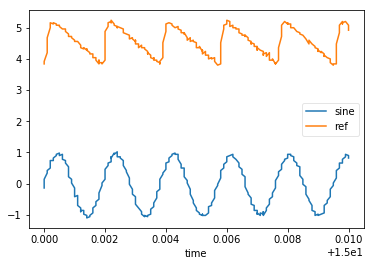

In [9]:
tsl = slice(15, 15.01)  # from 15 to 15.01 ms
df.loc[tsl].plot()

The signals have some higher frequency noise and some DC offset. The sawtooth wave will also have higher harmonics creating the sharp rise. Let's see them in the power spectrum.

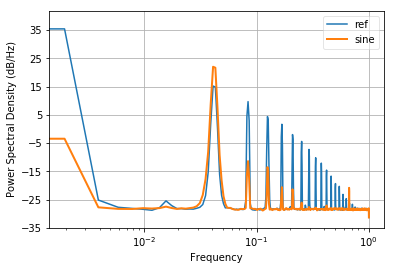

In [92]:
plt.psd(df['ref'], NFFT=2**10, label='ref');
plt.psd(df['sine'], NFFT=2**10, label='sine', lw=2);
plt.legend()
plt.xscale('log')

The main carrier frequency power is located between $[0.025,0.07]\cdot f_{nyq}$ in units of the Nyquist frequency $f_{nyq} = f_s/2$. The lower DC offset ($f=0$) or drift and higher harmonics must be removed with a bandpass filter.
Due to the frequency range of interest being very close to 0 we will construct a SOS (second-order-series) filter bank in order to ensure numerical stability.

In [26]:
sos = signal.iirfilter(16, [2.5e-2, 7e-2], btype='bandpass', ftype='butter', output='sos')

The `sosfitlfitl` function applied the filter from sstart to end and then backwards, ensuring 0 phase lag and doubling the filter effect.

In [31]:
df_filtered = df.apply(lambda c: signal.sosfiltfilt(sos, c), raw=True)
df_filtered.head()

sine       ref
time                        
-11.8130 -0.041280  0.019887
-11.8130  0.107929 -0.021377
-11.8129  0.255001 -0.062597
-11.8129  0.397289 -0.103556
-11.8128  0.532229 -0.144014

Let's inspect the result in teh frequency domain.

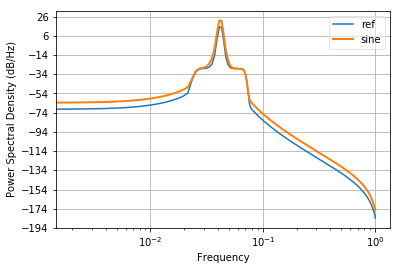

In [32]:
plt.psd(df_filtered['ref'], NFFT=2**10, label='ref');
plt.psd(df_filtered['sine'], NFFT=2**10, label='sine', lw=2);
plt.legend()
plt.xscale('log')

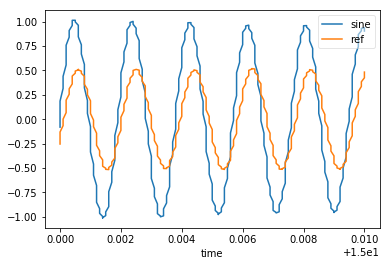

In [34]:
df_filtered.loc[tsl].plot()

In [35]:
df_hilbert = df_filtered.apply(signal.hilbert)
df_hilbert.head()

sine  \
time                                                   
-11.8130  (-0.04128027674543147-0.5309520373657165j)   
-11.8130   (0.10792875595317036-0.6933469352807132j)   
-11.8129     (0.255001416817121-0.7061632794737992j)   
-11.8129      (0.39728873639744-0.7230608313449303j)   
-11.8128    (0.5322286619388649-0.6813501045916028j)   

                                                   ref  
time                                                    
-11.8130    (0.019887434209465427+0.1912432232517734j)  
-11.8130  (-0.021377038974551673+0.24072560034150775j)  
-11.8129    (-0.06259713709388198+0.2507045194107817j)  
-11.8129    (-0.1035559627323997+0.26279599930216385j)  
-11.8128    (-0.14401369140592718+0.2598508756168212j)

In [36]:
df_phase = df_hilbert.apply(np.angle).apply(np.unwrap)
df_ampli = df_hilbert.apply(np.abs)

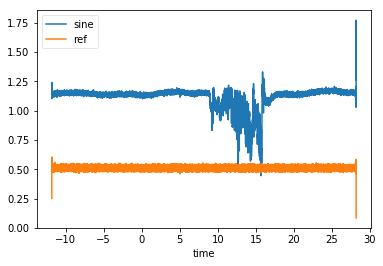

In [19]:
df_ampli.loc[::10].plot()

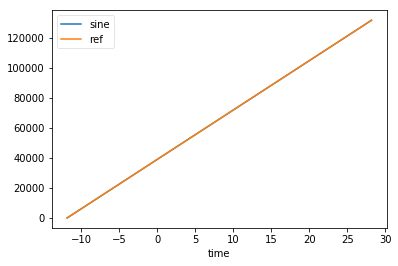

In [20]:
df_phase.plot()

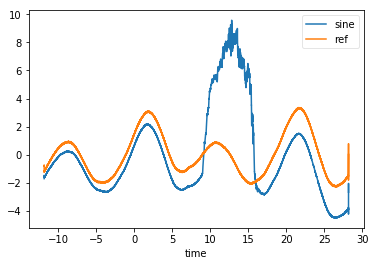

In [37]:
df_phase.apply(signal.detrend).plot()

In [38]:
phase_diff = df_phase['sine'] - df_phase['ref']
phase_diff_corr = phase_diff - phase_diff.loc[:5].mean()

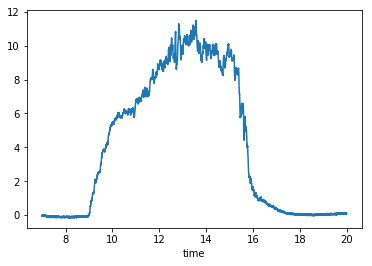

In [39]:
phase_diff_corr.loc[7:20].plot()

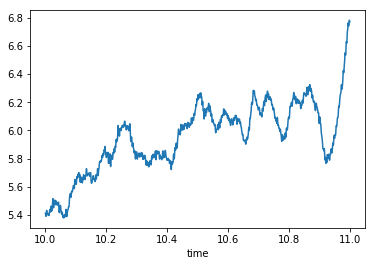

In [40]:
phase_diff_corr.loc[10:11].plot()

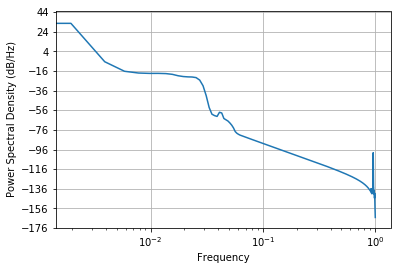

In [41]:
plt.psd(phase_diff_corr, NFFT=2**10);
plt.xscale('log')

# Comparison with the original algorithm

In [42]:
def original_algo(df, win_len=None):
    s_f = fftpack.fft(df.values[:,0], axis=0)
    n = s_f.shape[0]
    s_f[n//2:] = 0
    i_max = np.argmax(s_f, axis=0)
    s_f[:] = 0
    s_f[i_max] = 1
    cx_exp = fftpack.ifft(s_f)
    res = df.apply(lambda c: c*cx_exp)
    if win_len:
        win = signal.windows.gaussian(win_len, win_len/3)
        res = res.apply(lambda c: signal.convolve(c, win))
    return res

In [43]:
def show_orig_algo_overview(decim=1000, win_len=None):
    df_orig = original_algo(df, win_len=win_len)

    df_orig_ampli = df_orig.apply(np.abs)
    df_orig_phase = df_orig.apply(np.angle).apply(np.unwrap)
    fgi, axs = plt.subplots(2, 1, sharex=True)
    df_orig_phase.loc[::decim].apply(signal.detrend).plot(ax=axs[0])
    axs[0].set_title('phase - lin. trend')
    df_orig_ampli.loc[::decim].apply(signal.detrend).plot(ax=axs[1])
    axs[1].set_title('amplitude')

## Algorithm without smoothing

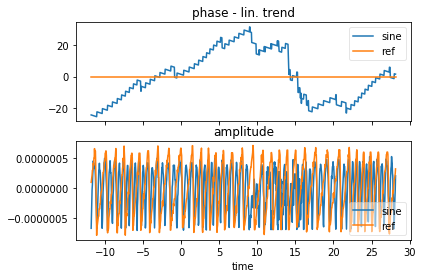

In [84]:
show_orig_algo_overview(win_len=None)

## Algorithm with Gaussian window convolution smoothing 

In [59]:
win_len = int(30e-3/dt)
win_len

750

/home/ondrej/anaconda3/lib/python3.7/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


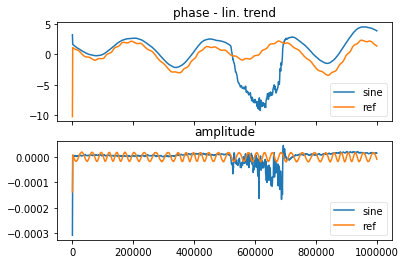

In [85]:
show_orig_algo_overview(win_len=win_len)